# 1. Import Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\imaja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\imaja\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\imaja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Import Data

This dataset contains 30,000 messages drawn from events including an earthquake in Haiti in 2010, an earthquake in Chile in 2010, floods in Pakistan in 2010, super-storm Sandy in the U.S.A. in 2012, and news articles spanning a large number of years and 100s of different disasters. The data has been encoded with 36 different categories related to disaster response and has been stripped of messages with sensitive information in their entirety. Upon release, this is the featured dataset of a new Udacity course on Data Science and the AI4ALL summer school and is especially utile for text analytics and natural language processing (NLP) tasks and models.The input data in this job contains thousands of untranslated disaster-related messages and their English translations. In the “Data” tab above, you’ll find the annotated data, with 40 class labels for intent and content.

In [2]:
from datasets import load_dataset

dataset = load_dataset("disaster_response_messages")

Generating train split:   0%|          | 0/21046 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2629 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2573 [00:00<?, ? examples/s]

In [33]:
df = pd.DataFrame(dataset['train'])

# 3. Basic EDA

genre
news      10450
direct     8666
social     1930
Name: count, dtype: int64


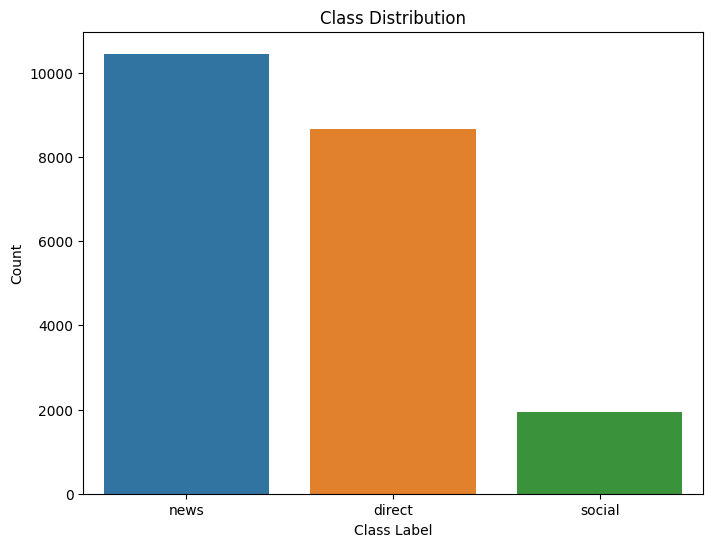

In [34]:
# Class Distribution
x=df['genre'].value_counts()
print(x)

# Check the class distribution
class_distribution = df['genre'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

# 4. Data Preprocessing

In [35]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [36]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df['clean_message'] = df['message'].apply(lambda x: finalpreprocess(x))
df.head()

,split,message,original,genre,related,PII,request,offer,aid_related,medical_help,...,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,clean_message
0,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,weather update cold front cuba could pass haiti
1,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,hurricane
2,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,say west side haiti rest country today tonight
3,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,information national palace
4,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,storm sacred heart jesus


# 5. Downsample Data

In [37]:
df = df.sample(n=2000)

# 6. Create Reference Sentiment Labels

Using TextBlob

In [38]:
from textblob import TextBlob

# Function to get sentiment label
def get_sentiment_label(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Distress'  # Positive sentiment
    elif analysis.sentiment.polarity < 0:
        return 'Relief'  # Negative sentiment
    else:
        return 'Neutral'  # Neutral sentiment

# Apply sentiment analysis and create 'Sentiment' column
df['Sentiment'] = df['clean_message'].apply(get_sentiment_label)

In [39]:
df.head()

,split,message,original,genre,related,PII,request,offer,aid_related,medical_help,...,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,clean_message,Sentiment
17777,train,The TNI will also send one infantry unit from ...,,news,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,tni also send one infantry unit bireuen simeul...,Neutral
241,train,"so, in the message you spoke of registering na...",Donk nan mesajla oupale de anrejistreman non m...,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,message speak register name like know purpose ...,Neutral
6449,train,send the name of cyclone that will be happend ...,Voye non cyclone kap pase yo pou mwen silvoupl :,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,send name cyclone happend country please,Neutral
9199,train,"Waters gone, no electricity till at least Wedn...",,social,1,0,1,0,1,0,...,1,1,1,0,0,0,0,1,water go electricity till least wednesday leav...,Relief
17047,train,Hundreds of apartments and other buildings wer...,,news,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,hundred apartment building either completely d...,Relief


Sentiment
Neutral     894
Distress    711
Relief      395
Name: count, dtype: int64


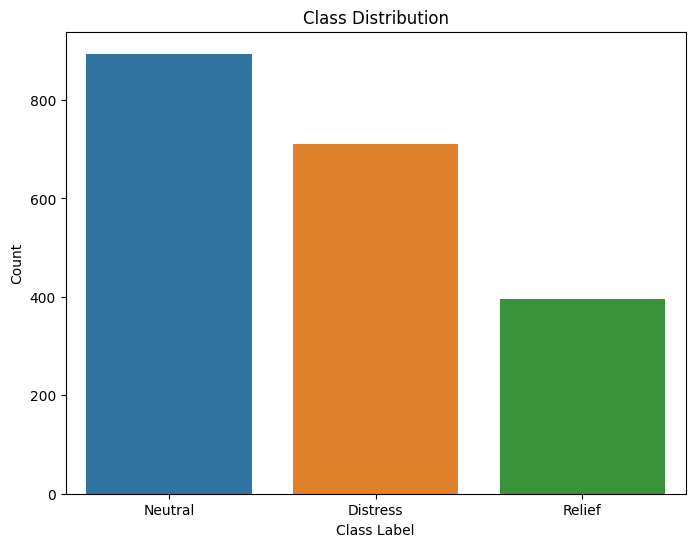

In [40]:
# Class Distribution
x=df['Sentiment'].value_counts()
print(x)

# Check the class distribution
class_distribution = df['Sentiment'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.utils import to_categorical

# Encode the target variable
label_encoder = LabelEncoder()
df['Sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['clean_message'], df['Sentiment_encoded'], test_size=0.2, random_state=42)

# Tokenization
# Tokenization is the process of breaking down text into smaller units, 
# such as words or characters. It is a fundamental step in natural language processing tasks, 
# enabling machines to understand and process human language effectively. 
# Word Tokenization: ["Tokenization", "is", "an", "important", "step", "in", "natural", "language", "processing", "."]

max_words = 2000
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# RNN Model for multi-class classification
embedding_dim = 200 #each word in the vocabulary will be represented by a dense vector of length 100 in the embedding space
num_classes = 3  # Three unique labels
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))  # Adjusting output layer for multi-class classification
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
epochs = 10
batch_size = 64
history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_pad, y_test), verbose=1)

# Evaluate the model
score = model.evaluate(X_test_pad, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
25/25 [==============================] - 27s 911ms/step - loss: 1.0263 - accuracy: 0.4669 - val_loss: 0.9730 - val_accuracy: 0.5475
Epoch 2/10
25/25 [==============================] - 22s 870ms/step - loss: 0.9200 - accuracy: 0.5844 - val_loss: 0.9035 - val_accuracy: 0.5725
Epoch 3/10
25/25 [==============================] - 17s 699ms/step - loss: 0.7598 - accuracy: 0.6594 - val_loss: 0.8005 - val_accuracy: 0.6225
Epoch 4/10
25/25 [==============================] - 25s 1s/step - loss: 0.4771 - accuracy: 0.8263 - val_loss: 0.7362 - val_accuracy: 0.7025
Epoch 5/10
25/25 [==============================] - 21s 847ms/step - loss: 0.2469 - accuracy: 0.9294 - val_loss: 0.7640 - val_accuracy: 0.7275
Epoch 6/10
25/25 [==============================] - 24s 979ms/step - loss: 0.1212 - accuracy: 0.9669 - val_loss: 0.7913 - val_accuracy: 0.7225
Epoch 7/10
25/25 [==============================] - 25s 989ms/step - loss: 0.0831 - accuracy: 0.9825 - val_loss: 0.9246 - val_accuracy: 0.7425
Ep

# 7. Test with an actual usecase

In [46]:
# Let's assume you have a single use case message
use_case_message = "Emergency! An earthquake has struck! Seek shelter immediately and stay safe. 🚨 #EarthquakeAlert"

# Tokenization (using the same tokenizer as before)
use_case_seq = tokenizer.texts_to_sequences([use_case_message])

# Padding (using the same max_len as before)
use_case_pad = pad_sequences(use_case_seq, maxlen=max_len)

# Use the model to make predictions
predictions = model.predict(use_case_pad)

# Interpret the results
# Since you're using softmax activation, you'll have probabilities for each class
# You can interpret the class with the highest probability as the predicted sentiment
predicted_class = predictions.argmax(axis=-1)

# Decode the predicted class using the label encoder
predicted_sentiment = label_encoder.inverse_transform(predicted_class)

print("Use Case Message:", use_case_message)
print("Predicted Sentiment:", predicted_sentiment)


1/1 [==============================] - 0s 56ms/step
Use Case Message: Emergency! An earthquake has struck! Seek shelter immediately and stay safe. 🚨 #EarthquakeAlert
Predicted Sentiment: ['Distress']
